In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

<Axes: xlabel='DATE'>

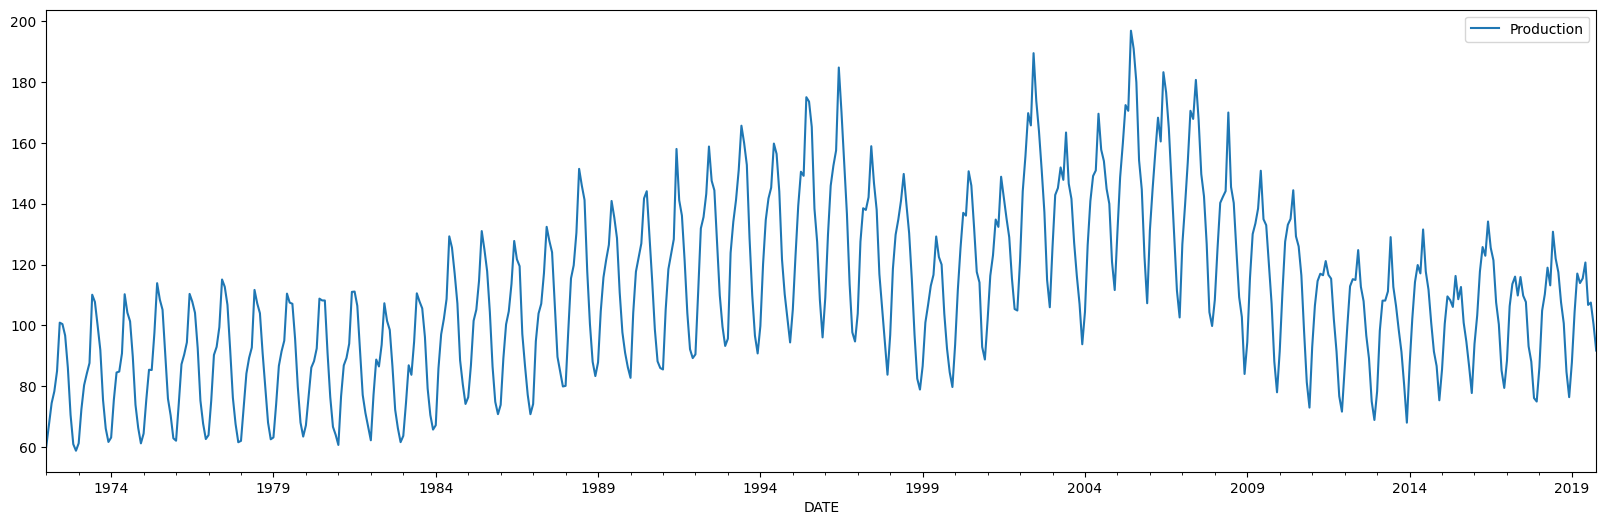

In [2]:
df = pd.read_csv('../DATA/IPN31152N.csv', parse_dates=True, index_col='DATE')

df.columns = ['Production']

df.plot(figsize=(20, 6))

In [3]:
print(f'{len(df) = }, {len(df) - 18 = }')

len(df) = 574, len(df) - 18 = 556


In [4]:
test_size = 18
test_ind = len(df) - test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [5]:
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [6]:
length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

X,y = generator[0]
len(X[0])

12

In [19]:
model = Sequential()
model.add(LSTM(180, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')


validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.summary()

C:\Users\aashi\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 180)            │       131,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,221 (512.58 KB)

 Trainable params: 131,221 (512.58 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295

C:\Users\aashi\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


544/544 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0295 - val_loss: 0.0044
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 9/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 10/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 11/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0021


<Axes: >

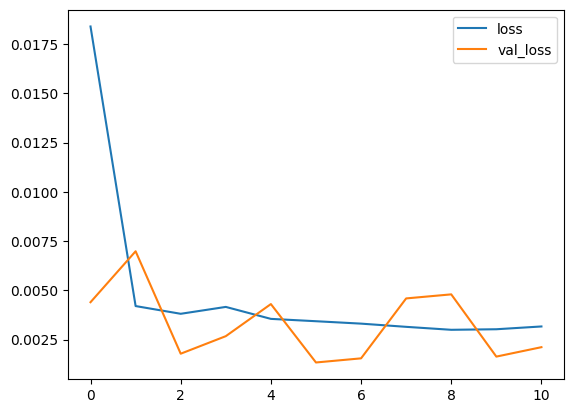

In [21]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [22]:
test_predictions = []
first_evaluation_batch = scaled_train[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions
test[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\aashi\AppData\Local\Temp\ipykernel_7808\1977277949.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Production,Predictions
DATE,,
2018-05-01,113.1661,123.668312
2018-06-01,130.7924,124.194448
2018-07-01,121.9881,119.150252
2018-08-01,117.4776,108.893229
2018-09-01,107.5556,95.490885
2018-10-01,100.6894,83.582013
2018-11-01,84.7973,78.099483
2018-12-01,76.4443,82.770554
2019-01-01,87.8427,95.546547


<Axes: xlabel='DATE'>

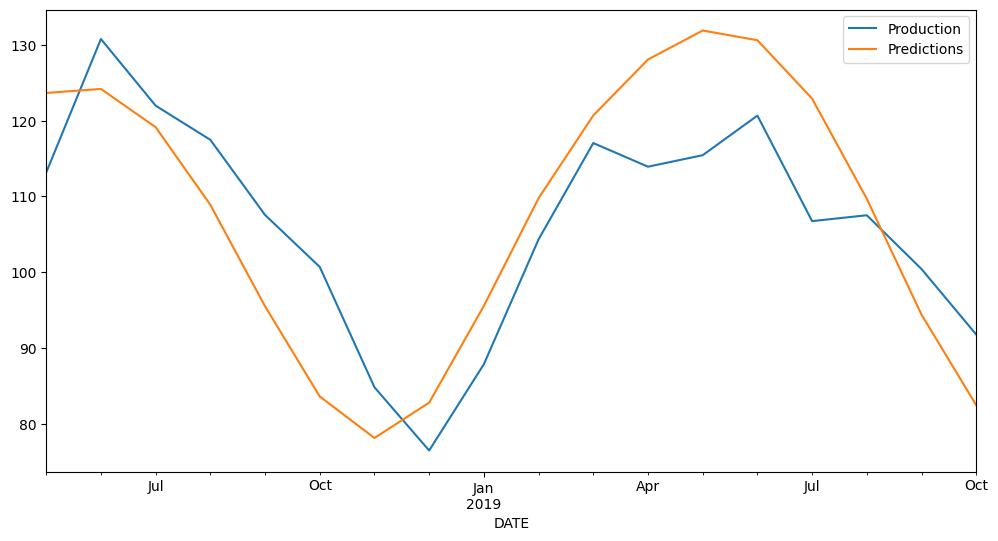

In [23]:
test.plot(figsize=(12,6))

In [24]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

np.float64(10.057907719277702)